In [36]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import string
import re
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import torch
import os
import torch.nn.functional as F  # Import F for padding

# Path to the directory containing the saved NumPy arrays
NUMPY_DIR = "keystroke_spectrograms/numpy_arrays"

# Function to load all spectrograms from the directory
def load_spectrograms_from_directory(directory):
    spectrograms = []
    keys = []
    widths = []
    filenames = os.listdir(directory)

    # Loop through each file in the directory
    for filename in filenames:
        if filename.endswith('.npy'):
            file_path = os.path.join(directory, filename)

            # Load the NumPy array from file
            spectrogram = np.load(file_path)

            widths.append(spectrogram.shape[1])

            key = re.search(r"keystroke_\d+_([A-Za-z])\.npy", filename).group(1)

            # Convert the spectrogram to a PyTorch tensor
            # Adding a channel dimension (1, height, width) for CNN input
            spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).float()  # Shape: (1, n_freq_bins, n_time_bins)

            # next, add the tensor to a list
            spectrograms.append(spectrogram_tensor)
            keys.append(key)

    return spectrograms, keys, max(widths)

# Load all spectrograms from the specified directory
spectrogram_tensors, keys, max_width = load_spectrograms_from_directory(NUMPY_DIR)

assert len(spectrogram_tensors) == len(keys), "The number of spectrograms and keys do not match!"


## Need to pad the spectrograms to the same width

# Padding function
def pad_tensor(tensor, max_height):
    # Calculate padding size (for the width dimension)
    current_width = tensor.shape[2]  # Index 2 is for the time dimension (width)
    if current_width < max_height:
        padding = max_height - current_width
        # Pad with zeros on the right (width dimension)
        return F.pad(tensor, (0, padding))  # Pad (left, right)
    if current_width >= max_height:
        print("Warning: Tensor overshoots the limit height")
        return tensor[:, :, :max_height]
    # the tensor overshoots the limit so we consider it an outlier
    return tensor

# Apply padding to all spectrograms
for i in range(len(spectrogram_tensors)):
        if (padded := pad_tensor(spectrogram_tensors[i], 300)) is not None:
            spectrogram_tensors[i] = padded


# Verify padding
for i, spectrogram in enumerate(spectrogram_tensors):
    print(f"Shape of spectrogram {i}: {spectrogram.shape}")


Shape of spectrogram 0: torch.Size([1, 129, 300])
Shape of spectrogram 1: torch.Size([1, 129, 300])
Shape of spectrogram 2: torch.Size([1, 129, 300])
Shape of spectrogram 3: torch.Size([1, 129, 300])
Shape of spectrogram 4: torch.Size([1, 129, 300])
Shape of spectrogram 5: torch.Size([1, 129, 300])
Shape of spectrogram 6: torch.Size([1, 129, 300])
Shape of spectrogram 7: torch.Size([1, 129, 300])
Shape of spectrogram 8: torch.Size([1, 129, 300])
Shape of spectrogram 9: torch.Size([1, 129, 300])
Shape of spectrogram 10: torch.Size([1, 129, 300])
Shape of spectrogram 11: torch.Size([1, 129, 300])
Shape of spectrogram 12: torch.Size([1, 129, 300])
Shape of spectrogram 13: torch.Size([1, 129, 300])
Shape of spectrogram 14: torch.Size([1, 129, 300])
Shape of spectrogram 15: torch.Size([1, 129, 300])
Shape of spectrogram 16: torch.Size([1, 129, 300])
Shape of spectrogram 17: torch.Size([1, 129, 300])
Shape of spectrogram 18: torch.Size([1, 129, 300])
Shape of spectrogram 19: torch.Size([1, 1

In [39]:
class KeystrokeDataset(Dataset):
    def __init__(self, spectrograms_tensors, labels):
        self.spectrograms = spectrograms_tensors
        self.labels = labels

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]
    
tensors,labels, _ = load_spectrograms_from_directory(NUMPY_DIR)

## convert the keystroke tuple into a tensor
tensors = spectrogram_tensors # adjusting the tensors to the padded spectrograms
alphabet = "abcdefghijklmnopqrstuvwxyz"
char2idx = {char: idx for idx, char in enumerate(alphabet)}
label_indices = [char2idx[char] for char in labels]

label_tensor = torch.tensor(label_indices, dtype=torch.long)

train_dataset = KeystrokeDataset(spectrogram_tensors,label_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Character labels:", labels)
print("Converted Tensor:", label_tensor)

#test_dataset = KeystrokeDataset(test_spectrograms_tensors, test_labels)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Character labels: ['n', 's', 'j', 't', 'x', 'f', 'g', 'g', 't', 'r', 'f', 'g', 'n', 'a', 'b', 'i', 'u', 'j', 'h', 'z', 'm', 'f', 'h', 'y', 'd', 'g', 's', 'w', 'f', 'k', 'd', 'd', 'j', 'c', 'c', 'w', 'j', 'e', 'y', 'l', 'x', 'g', 'd', 'j', 'j', 'c', 'i', 'u', 'w', 'f', 'g', 'l', 'i', 'j', 'f', 'd', 'f', 'p', 'n', 'r', 'i', 'o', 'p', 'b', 't', 'l', 'h', 'j', 'i', 't', 'r', 'u', 'y', 's', 'l', 'q', 'g', 'd', 'l', 'h', 'o', 'g', 't', 'k', 'j', 'l', 'i', 'y', 'h', 't', 'v', 's', 'e', 'y', 'v', 'l', 'g', 'h', 'm', 'g', 'f', 'f', 'j', 'v', 'h', 'u', 'j', 'u', 'u', 'f', 'm', 'd', 's', 'o', 'p', 'f', 'c', 'm', 'j', 'g', 't', 'e', 'd', 's', 'q', 'z', 'f', 'd', 't', 't', 'u', 'h', 'j', 'g', 'z', 'p', 'r', 'h', 'y', 'd', 'h', 'k', 'q', 'y', 'd', 'g', 'k', 't', 'r', 'c', 'r', 'i', 'k', 'i', 'u', 'h', 'r', 'w', 'h', 'k', 'b', 'h', 'j', 't', 'y', 'y', 'o', 'e', 's', 'g', 'l', 'd', 'h', 'r', 'q', 'k', 'n', 'p', 't', 'y', 'h', 't', 'o', 'u', 'y', 's', 'b', 't', 'j', 'g', 'u', 'a', 'v', 'x', 'g', 'f', '

In [55]:
class KeystrokeCNN(nn.Module):
    def __init__(self,input_height=129, input_width=300, num_classes=26):
        super(KeystrokeCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, H, W) -> (32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (32, H, W) -> (64, H, W)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (64, H, W) -> (128, H, W)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half (H/2, W/2)

        # Calculate the final feature map size dynamically
        self._to_linear = self._get_conv_output_size(input_height, input_width)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)  
        self.fc2 = nn.Linear(512, num_classes)  # 26 output classes (A-Z)
        #list(string.ascii_lowercase) for generating the output classes

    def _get_conv_output_size(self, height, width):
        """Pass a dummy tensor to determine final feature map size after convolutions"""
        x = torch.zeros(1, 1, height, width)  # Batch size = 1, 1 channel, (H, W)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x.numel()  # Flattened size
    
    def forward(self, x):
        #print("Input shape:", x.shape)
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
       # print("After conv1+pool:", x.shape)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
       # print("After conv2+pool:", x.shape)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
       # print("After conv3+pool:", x.shape)
        
        x = x.view(x.size(0), -1)
        #print("After flattening:", x.shape)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = KeystrokeCNN()




In [56]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1 average loss: 23.747
Epoch 2 average loss: 3.290
Epoch 3 average loss: 3.183
Epoch 4 average loss: 3.096
Epoch 5 average loss: 2.979
Epoch 6 average loss: 2.871
Epoch 7 average loss: 2.818
Epoch 8 average loss: 2.686
Epoch 9 average loss: 2.598
Epoch 10 average loss: 2.425


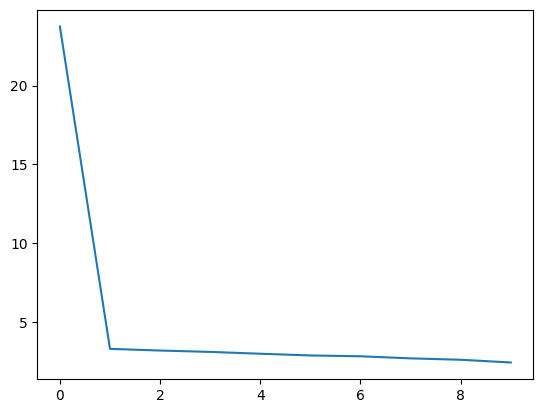

In [57]:
# Function to train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_losses = []
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            
            try:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                epoch_losses.append(loss.item())
                
                if i % 10 == 9:  # Print every 10 batches
                    print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
                    running_loss = 0.0
                    
            except Exception as e:
                print("Input tensors may not be of the right shape", e)
                raise e
        
        # Store average loss for this epoch
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {avg_epoch_loss:.3f}")
    
    return losses

epochs = 10
losses =train(model, train_loader, criterion, optimizer, epochs)

plt.plot(range(epochs), losses)
plt.show()


torch.Size([1, 129, 300])
Predicted letter: t
actual letter: n
torch.Size([1, 129, 300])
Predicted letter: f
actual letter: s
torch.Size([1, 129, 300])
Predicted letter: f
actual letter: j
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: t
torch.Size([1, 129, 300])
Predicted letter: x
actual letter: x
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: f
torch.Size([1, 129, 300])
Predicted letter: l
actual letter: g
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: g
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: t
torch.Size([1, 129, 300])
Predicted letter: j
actual letter: r
torch.Size([1, 129, 300])
Predicted letter: f
actual letter: f
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: g
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: n
torch.Size([1, 129, 300])
Predicted letter: s
actual letter: a
torch.Size([1, 129, 300])
Predicted letter: t
actual letter: b
torch.Size([1, 129, 300])
Predicted letter: b
actual le

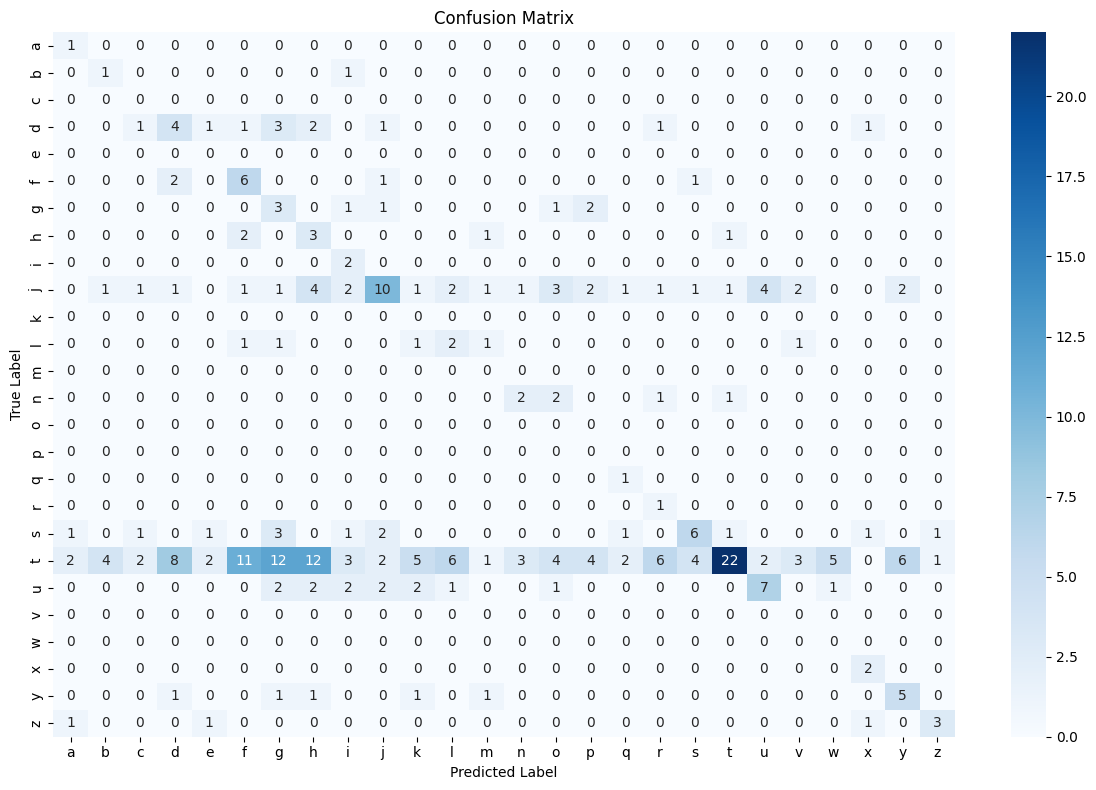

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define character mapping (should match what you used in training)
letters = "abcdefghijklmnopqrstuvwxyz"
idx2char = {i: c for i, c in enumerate(letters)}

def predict(model, spectrogram_tensor):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # No need to compute gradients
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension (1, 1, 129, 300)
        output = model(spectrogram_tensor)  # Forward pass
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_idx = torch.argmax(probabilities, dim=1).item()  # Get class index
        predicted_letter = idx2char[predicted_idx]  # Convert index to letter
        
    return predicted_letter


def crop_spectrogram(tensor, target_width=300):
    return tensor[:, :, :target_width]  # Keep only the first 101 columns


spectrogram_tensors, keys, max_width = load_spectrograms_from_directory(NUMPY_DIR)
# torch.Size([1, 1, 129, *])
TP = 0
FP = 0
TN = 0
FN = 0

y_hat = []
for i in range(len(spectrogram_tensors)):
    test_tensor = pad_tensor(spectrogram_tensors[i], max_height=300) 
    print(test_tensor.shape)
    predicted_letter = predict(model, test_tensor)
    y_hat.append(predicted_letter)
    print(f"Predicted letter: {predicted_letter}")
    print("actual letter:", keys[i])
    if predicted_letter == keys[i]:
        TP += 1
    else:
        FP += 1
    if predicted_letter != keys[i]:
        TN += 1
    else:
        FN += 1

print("accuracy:", (TP + TN) / (TP + TN + FP + FN))
print("precision:", TP / (TP + FP))
print("recall:", TP / (TP + FN))
print("F1 score:", 2 * TP / (2 * TP + FP + FN))

cm= confusion_matrix(y_hat, keys)
plt.figure(figsize=(12, 8))
classes = list(letters) 
sns.heatmap(cm, 
            annot=True,  # Show numbers in each cell
            fmt='d',     # Format as integers
            cmap='Blues', # Color scheme
            xticklabels=classes,  # Labels on x-axis: ['a', 'b', 'c', ..., 'z']
            yticklabels=classes) 
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

